In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import importlib

In [4]:
from glob import glob

In [5]:
files_loc = "/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Apr2022/si-mu-lator/batch_slac/out_files/bkgr_0/"

In [6]:
all_files = glob(files_loc+'*.h5')

In [7]:
import dataprep
importlib.reload(dataprep)

<module 'dataprep' from '/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Feb15/si-mu-lator/nn/notebooks/dataprep.py'>

In [8]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = dataprep.make_data_matrix(all_files, max_files=500, sort_by='z')

/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Apr2022/si-mu-lator/batch_slac/out_files/bkgr_0/WithMuon.atlas_mm_road.nevs_1000.bkgr_0.mux.-2.0.2.0_Rnd480354.h5
['is_muon', 'x', 'y', 'z', 'ptype', 'ptilt', 'poffset', 'time', 'projX_at_rightend_x', 'projX_at_rightend_y', 'projX_at_middle_x', 'projX_at_middle_y', 'projY_at_topend_x', 'projY_at_topend_y', 'projY_at_middle_x', 'projY_at_middle_y', 'seg_ix', 'rdrift']
/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Apr2022/si-mu-lator/batch_slac/out_files/bkgr_0/WithMuon.atlas_mm_road.nevs_1000.bkgr_0.mux.-2.0.2.0_Rnd480355.h5
/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Apr2022/si-mu-lator/batch_slac/out_files/bkgr_0/WithMuon.atlas_mm_road.nevs_1000.bkgr_0.mux.-2.0.2.0_Rnd480418.h5
/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Apr2022/si-mu-lator/batch_slac/out_files/bkgr_0/WithMuon.atlas_mm_road.nevs_1000.bkgr_0.mux.-2.0.2.0_Rnd480402.h5
/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/Apr2022/si-mu-lator/batch_slac/out_files/bkgr_0/WithMuon.atlas_mm_road.nevs_1000.bkgr_0.mux.-2.0.2.0_Rn

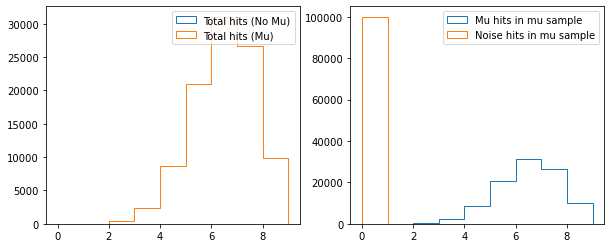

In [9]:
ncols=2
nrows=1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

axs[0].hist(data['ev_n_signals'][Y_mu==0], histtype='step', bins=9, range=(0,9), label='Total hits (No Mu)')
axs[0].hist(data['ev_n_signals'][Y_mu==1], histtype='step', bins=9, range=(0,9), label='Total hits (Mu)')
axs[0].legend()

axs[1].hist(data['ev_n_mu_signals'][Y_mu==1], histtype='step', bins=9, range=(0,9), label='Mu hits in mu sample')
axs[1].hist(data['ev_n_signals'][Y_mu==1]-data['ev_n_mu_signals'][Y_mu==1], histtype='step', bins=9, range=(0,9), label='Noise hits in mu sample')
axs[1].legend()

plt.show()

In [10]:
dmat[:,:,0]> -1

array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True, False]])

In [11]:
np.sum(dmat[:,:,0], axis=1, where=dmat[:,:,0]>-1)

array([7., 7., 7., ..., 5., 6., 7.])

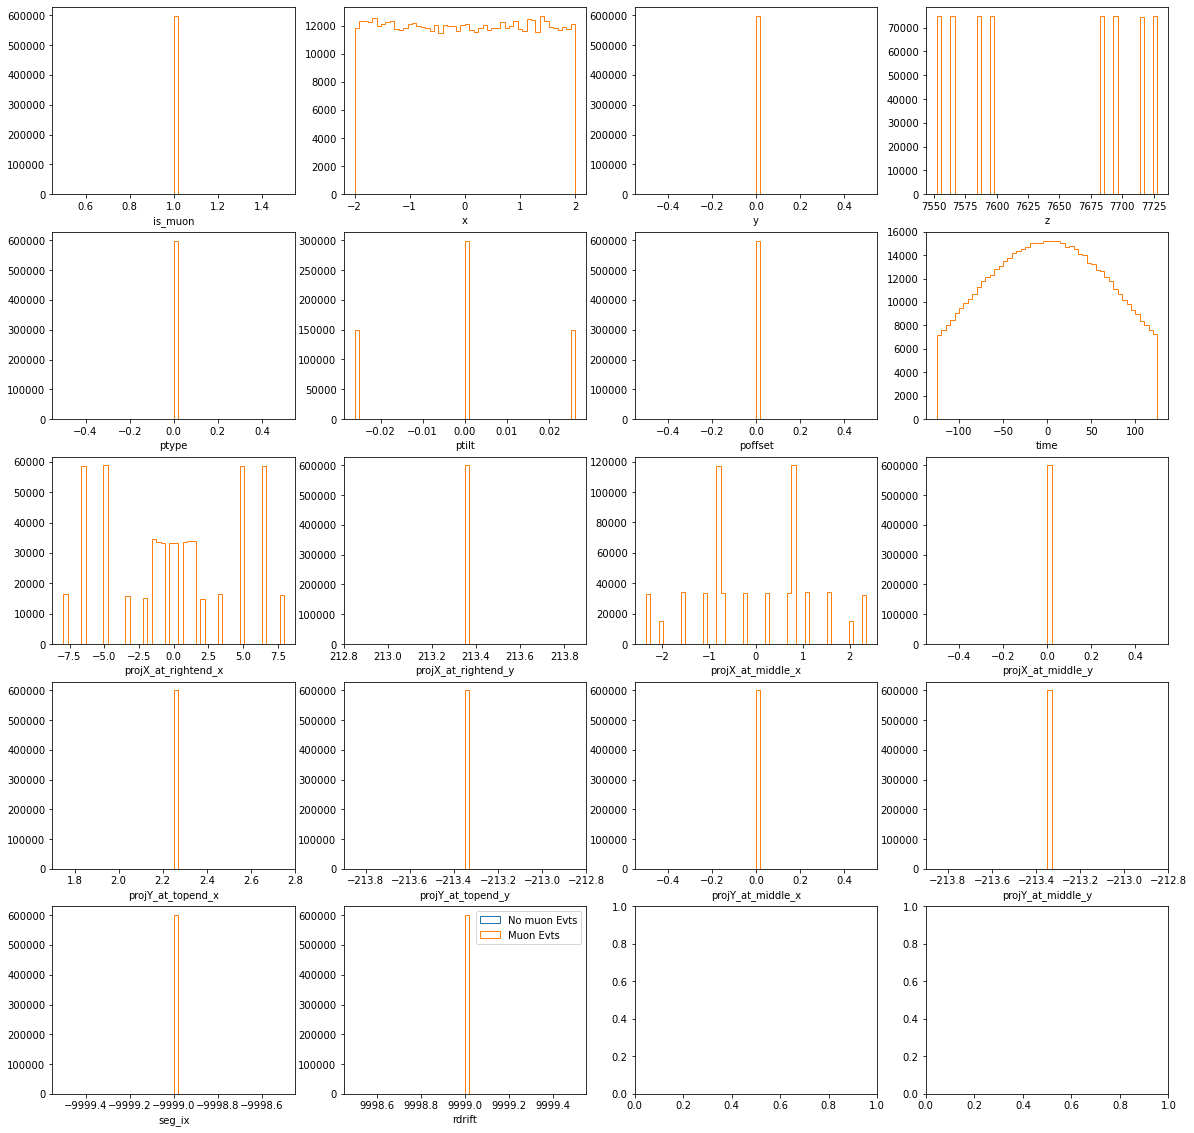

In [12]:
ncols=4
nrows=5
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))
axs = axs.flatten()

for ivar in range(dmat.shape[2]):

    valid_hits_mu   = dmat[Y_mu == 1,:,sig_keys.index('is_muon')].flatten() > -90
    valid_hits_nomu = dmat[Y_mu == 0,:,sig_keys.index('is_muon')].flatten() > -90

    this_var_mu   = dmat[Y_mu == 1,:,ivar].flatten()[valid_hits_mu]
    this_var_nomu = dmat[Y_mu == 0,:,ivar].flatten()[valid_hits_nomu]
    
    this_max = np.max([*this_var_mu, *this_var_nomu])
    this_min = np.min([*this_var_mu, *this_var_nomu])
        
    axs[ivar].hist( this_var_nomu, histtype='step', range=(this_min, this_max), bins=50, label = 'No muon Evts'  )
    axs[ivar].hist( this_var_mu, histtype='step', range=(this_min, this_max), bins=50, label = 'Muon Evts' )    

    axs[ivar].set_xlabel(sig_keys[ivar])
    
    if ivar == dmat.shape[2] - 1:
        axs[ivar].legend()
    
plt.show()

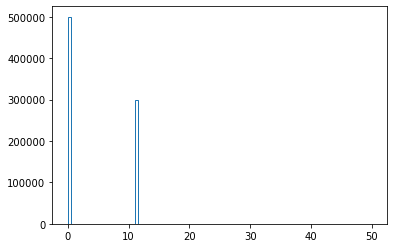

In [16]:
plt.Figure()
plt.hist( 2*np.abs(dmat[:,:,8].flatten() - dmat[:,:,10].flatten()), histtype='step', bins=100, range=(0, 50) )
plt.show()